In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle api
!kaggle datasets download muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 309M/309M [00:01<00:00, 312MB/s]
100% 309M/309M [00:01<00:00, 285MB/s]


In [ ]:
from zipfile import ZipFile
file_name = '/content/human-emotions-datasethes.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
import keras
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.layers import InputLayer, Dense, Dropout, MaxPool2D, Conv2D, BatchNormalization, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2 as cv
from sklearn.metrics import confusion_matrix

In [ ]:
train_dir = '/content/Emotions Dataset/Emotions Dataset/train'
val_dir = '/content/Emotions Dataset/Emotions Dataset/test'

In [ ]:
img_size = 224
batch_size = 32

In [ ]:
class_names = ['angry', 'happy', 'sad']

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=99,
)


Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


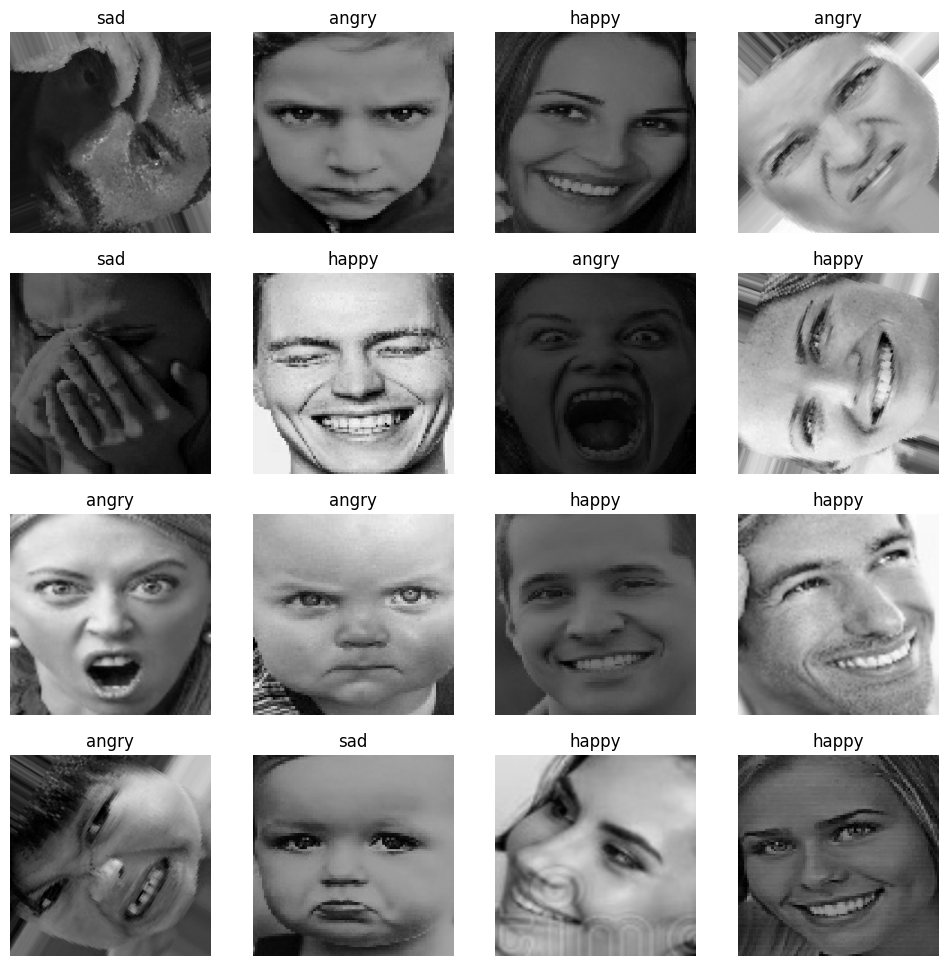

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(class_names[tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")

In [ ]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
model = tf.keras.Sequential([
    InputLayer(shape = (img_size, img_size, 3)),
    backbone,
    layers.GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(3 , activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [ ]:
checkpoint = ModelCheckpoint('C:/Users/priya/OneDrive/Desktop/best_weights.keras',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            verbose = 1,
                            save_best_only=True)

In [ ]:
model.compile(optimizer = 'adam',
                 loss = 'CategoricalCrossentropy',
                 metrics = ['accuracy', TopKCategoricalAccuracy( k=2, name = 'top_k_accuracy')]
                 )

In [ ]:
history = model.fit(
     train_dataset,
     epochs = 20,
     validation_data = val_dataset,
     verbose = 1,
     callbacks = [checkpoint]
 )

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7173 - loss: 0.6836 - top_k_accuracy: 0.9261
Epoch 1: val_accuracy improved from -inf to 0.72081, saving model to C:/Users/priya/OneDrive/Desktop/best_weights.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 132s 296ms/step - accuracy: 0.7173 - loss: 0.6835 - top_k_accuracy: 0.9260 - val_accuracy: 0.7208 - val_loss: 0.7184 - val_top_k_accuracy: 0.9096
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7779 - loss: 0.5308 - top_k_accuracy: 0.9400
Epoch 2: val_accuracy improved from 0.72081 to 0.74846, saving model to C:/Users/priya/OneDrive/Desktop/best_weights.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.7779 - loss: 0.5308 - top_k_accuracy: 0.9400 - val_accuracy: 0.7485 - val_loss: 0.5789 - val_top_k_accuracy: 0.9249
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8188 - loss: 0.4380 - top_k_accuracy: 0.9593
Epoch 3: val_accuracy improved from 0.74846 to 0.76997, saving model to

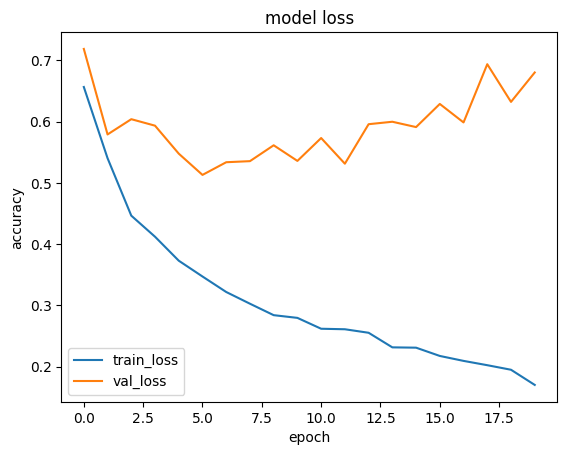

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

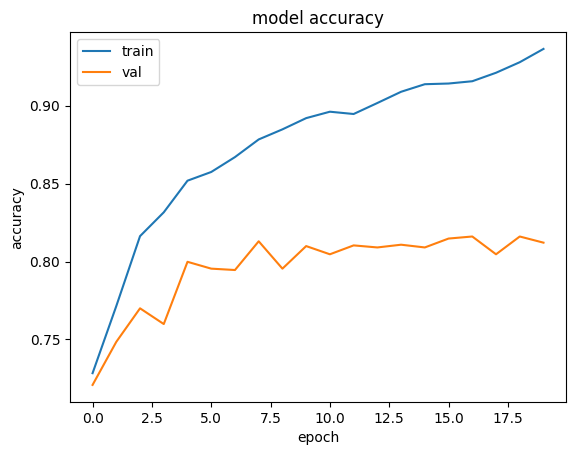

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8034 - loss: 0.6798 - top_k_accuracy: 0.9400


[0.679969847202301, 0.8121159076690674, 0.9424934387207031]

In [ ]:
test_img = cv.imread('/content/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg')
test_img = tf.expand_dims(test_img, axis = 0)
test_img.shape

TensorShape([1, 224, 224, 3])

In [ ]:
pred = model.predict(test_img)
pred_label = [np.argmax(i) for i in pred]
for i in pred_label:
    print(class_names[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
angry


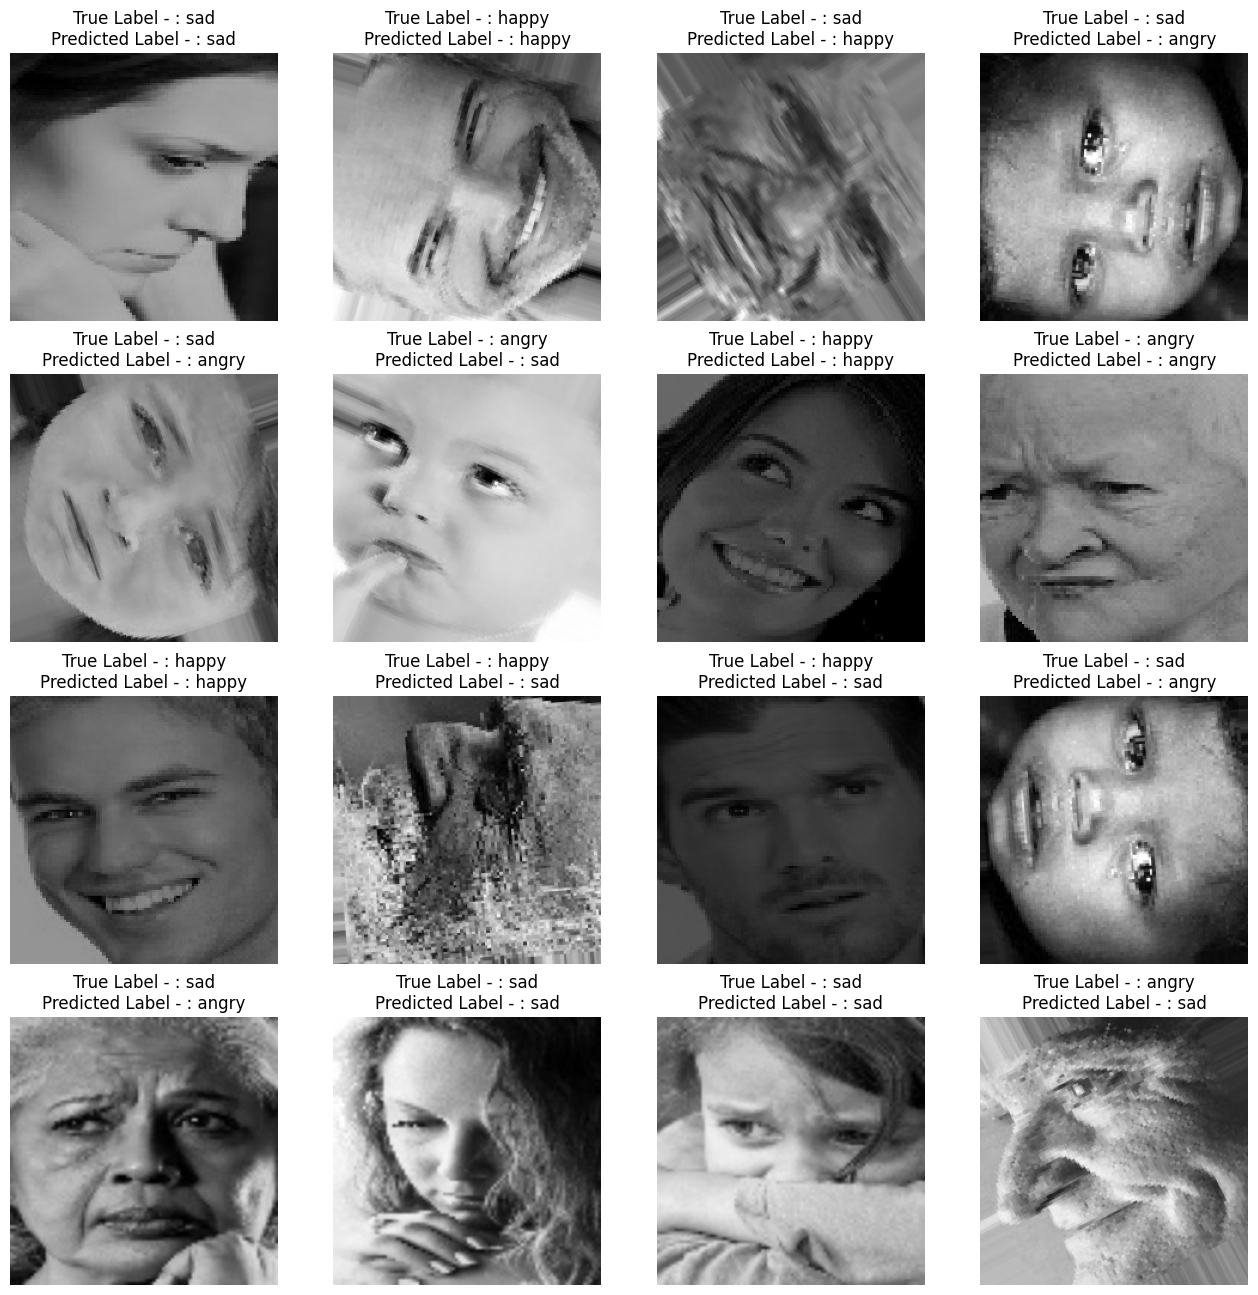

In [ ]:
plt.figure(figsize = (16,16))

for images, labels in val_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)

        plt.title("True Label - : " +class_names[tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + class_names[int(tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")


213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step


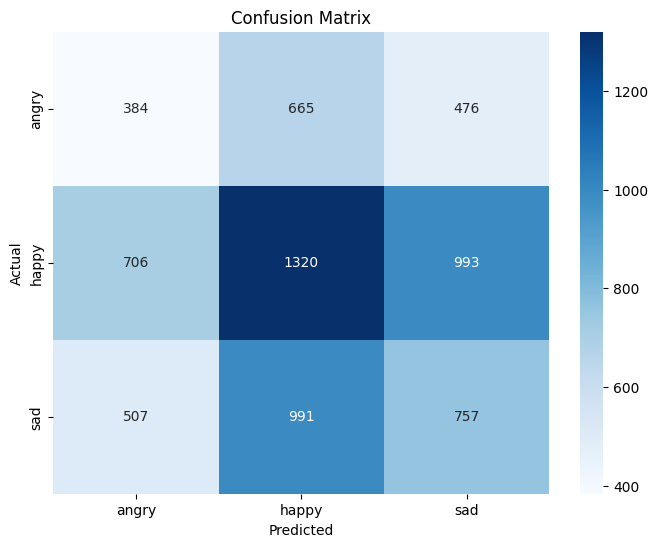

In [ ]:
import seaborn as sns


# Step 1: Extract y_true from val_dataset
y_true = []
for images, labels in train_dataset:  # Assuming val_dataset is batched
    y_true.extend(np.argmax(labels.numpy(), axis=-1))  # Extract true labels

# Step 2: Get predictions
Y_pred = model.predict(train_dataset)  # Predict on validation dataset
y_pred = np.argmax(Y_pred, axis=1)   # Get predicted labels

# Step 3: Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## Fine Tune ##

In [ ]:
backbone.trainable = True

In [ ]:
input =  layers.Input(shape = (img_size, img_size, 3))

x = backbone(input, training = False)

x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)

output = Dense(3 , activation = 'softmax')(x)

finetuned_model = keras.Model(input, output)

In [ ]:
finetuned_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

In [ ]:
finetuned_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-3/100),
                 loss = 'CategoricalCrossentropy',
                 metrics = ['accuracy', TopKCategoricalAccuracy( k=2, name = 'top_k_accuracy')]
                 )

In [ ]:
history = finetuned_model.fit(
     train_dataset,
     epochs = 20,
     validation_data = val_dataset,
     verbose = 1,
     #callbacks = [checkpoint]
 )

In [ ]:
base = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size, img_size, 3)

)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)